In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Model Architecture
![model_architecture.png](./model_architecture.png)

In [2]:
ISEAR_CSV = "./datasets_csv/ISEAR_dataset.csv"
CLASS_LABELS = ['Anger', 'Fear', 'Joy', 'Sadness']
BERT_CONFIG = "bert-base-uncased"
MAX_LEN = 256
BATCH_SIZE = 16
NUM_CLASSES = 4
LEARNING_RATE = 2e-5
EPOCHS = 10

In [3]:
class DualChannelModule(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dropout_val):
        super(DualChannelModule, self).__init__()
        self.channel1_bilstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.channel1_conv = nn.Conv1d(in_channels=lstm_hidden_size*2, out_channels=32, kernel_size=400)
        self.channel1_dropout = nn.Dropout(dropout_val)

        self.channel2_conv = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=400)
        self.channel2_dropout = nn.Dropout(dropout_val)
        self.channel2_bilstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)

    def forward(self, bert_embeddings):

        bert_embeddings = bert_embeddings.permute(0, 2, 1)                              # shape (BS, 768, 128)
        channel1_bilstm_output, _ = self.channel1_bilstm(bert_embeddings)               # shape (BS, 768, 32)
        channel1_bilstm_output = channel1_bilstm_output.permute(0, 2, 1)                # shape (BS, 32, 768)
        channel1_conv_output = self.channel1_conv(channel1_bilstm_output)               # shape (BS, 32, 369)
        channel1_output = self.channel1_dropout(channel1_conv_output)                   # shape (BS, 32, 369)

        bert_embeddings = bert_embeddings.permute(0, 2, 1)                              # shape (BS, 128, 768)
        channel2_conv_output = self.channel2_conv(bert_embeddings)                      # shape (BS, 32, 369)
        channel2_dropout_output = self.channel2_dropout(channel2_conv_output)           # shape (BS, 32, 369)
        channel2_dropout_output = channel2_dropout_output.permute(0, 2, 1)              # shape (BS, 369, 32)
        channel2_output, _ = self.channel2_bilstm(channel2_dropout_output)              # shape (BS, 369, 32)
        channel2_output = channel2_output.permute(0, 2, 1)                              # shape (BS, 32, 369)

        dual_channel_output = torch.cat((channel1_output, channel2_output), dim=2)      # shape (BS, 32, 768)
        return dual_channel_output


In [4]:
class ClassificationModule(nn.Module):
    def __init__(self, number_of_classes, dropout_val):
        super(ClassificationModule, self).__init__()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_val)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(in_features=11808, out_features=1000)
        self.dense2 = nn.Linear(in_features=1000, out_features=600)
        self.classification_output = nn.Linear(in_features=600, out_features=number_of_classes)

    def forward(self, dual_channel_output):
        maxpool_output = self.maxpool(dual_channel_output)                                         # shape (BS, 32, 369)
        dropout_output = self.dropout(maxpool_output)                                              # shape (BS, 32, 369)
        flatten_output = self.flatten(dropout_output)                                              # shape (BS, 11808)
        dense1_output = self.dense1(flatten_output)                                                # shape (BS, 1000)
        dense2_output = self.dense2(dense1_output)                                                 # shape (BS, 600)
        classification_output = F.softmax(self.classification_output(dense2_output), dim=1)        # shape (BS, 4)

        return classification_output

In [5]:
class TER(nn.Module):
    def __init__(self, number_of_classes, input_size, lstm_hidden_size=16, dropout_val=0.1):
        super(TER, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_CONFIG)
        self.dual_channel = DualChannelModule(input_size=input_size, lstm_hidden_size=lstm_hidden_size, dropout_val=dropout_val)
        self.classifier = ClassificationModule(number_of_classes, dropout_val)

    def forward(self, input_seq, attention_mask):
        bert_pooled_output = self.bert(input_seq, attention_mask=attention_mask)[0]     # A tensor of shape (batch_size, num_tokens=128, embedding_dim=768) containing BERT embeddings
        dual_channel_output = self.dual_channel(bert_pooled_output)                     # shape (BS, 32, 738)
        classification_output = self.classifier(dual_channel_output)                    # shape (BS, 4)
        return classification_output

In [6]:
def tokenize_sentences(sentences, tokenizer, max_length):
    tokenized_sequences = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return tokenized_sequences['input_ids'], tokenized_sequences['attention_mask']

In [7]:
ISEAR_dataset = pd.read_csv(ISEAR_CSV, index_col=0)
ISEAR_dataset

,ISEAR_labels,ISEAR_sentences
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,joy,When I got a letter offering me the Summer job...
...,...,...
4376,sadness,This issue worried me rather than saddening me...
4377,joy,I received a letter from a distant friend.
4378,fear,My parents were out and I was the eldest at ho...
4379,anger,Two years back someone invited me to be the tu...


In [8]:
ISEAR_dataset['ISEAR_labels'].value_counts()

,count
ISEAR_labels,
anger,1096
sadness,1096
fear,1095
joy,1094


In [9]:
ISEAR_train_data, ISEAR_val_data = train_test_split(ISEAR_dataset, test_size=0.1, random_state=42)
ISEAR_X_train = list(ISEAR_train_data['ISEAR_sentences'])
ISEAR_X_val = list(ISEAR_val_data['ISEAR_sentences'])
ISEAR_Y_train = list(ISEAR_train_data['ISEAR_labels'])
ISEAR_Y_val = list(ISEAR_val_data['ISEAR_labels'])

In [10]:
# Initialize XLM-RoBERTa tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_CONFIG)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
train_input_ids, train_attention_mask = tokenize_sentences(ISEAR_X_train, tokenizer, max_length=MAX_LEN)
val_input_ids, val_attention_mask = tokenize_sentences(ISEAR_X_val, tokenizer, max_length=MAX_LEN)

In [12]:
label_encoder = preprocessing.LabelEncoder()
ISEAR_Y_train_encoded = label_encoder.fit_transform(ISEAR_Y_train)
ISEAR_Y_val_encoded = label_encoder.fit_transform(ISEAR_Y_val)

In [13]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(ISEAR_Y_train_encoded, dtype=torch.int64)
val_labels = torch.tensor(ISEAR_Y_val_encoded, dtype=torch.int64)

In [14]:
# Creating Dataloaders
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [15]:
# Initializing the model
model = TER(number_of_classes=NUM_CLASSES, input_size=MAX_LEN)

In [16]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [18]:
# Training the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_seq, attention_mask, labels) in enumerate(train_loader):
        input_seq = input_seq.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(input_seq, attention_mask)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f"Epoch [{epoch + 1}/{EPOCHS}] "
                  f"Batch [{batch_idx + 1}/{len(train_loader)}] "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

Epoch [1/10] Batch [100/247] Loss: 1.1262
Epoch [1/10] Batch [200/247] Loss: 0.9684
Epoch [2/10] Batch [100/247] Loss: 0.8995
Epoch [2/10] Batch [200/247] Loss: 0.8894
Epoch [3/10] Batch [100/247] Loss: 0.8718
Epoch [3/10] Batch [200/247] Loss: 0.8626
Epoch [4/10] Batch [100/247] Loss: 0.8420
Epoch [4/10] Batch [200/247] Loss: 0.8663
Epoch [5/10] Batch [100/247] Loss: 0.8379
Epoch [5/10] Batch [200/247] Loss: 0.8534
Epoch [6/10] Batch [100/247] Loss: 0.8454
Epoch [6/10] Batch [200/247] Loss: 0.8417
Epoch [7/10] Batch [100/247] Loss: 0.8288
Epoch [7/10] Batch [200/247] Loss: 0.8356
Epoch [8/10] Batch [100/247] Loss: 0.8388
Epoch [8/10] Batch [200/247] Loss: 0.8317
Epoch [9/10] Batch [100/247] Loss: 0.8255
Epoch [9/10] Batch [200/247] Loss: 0.8514
Epoch [10/10] Batch [100/247] Loss: 0.8180
Epoch [10/10] Batch [200/247] Loss: 0.8397


In [20]:
# Evaluating the model
model.eval()
total_correct = 0
total_samples = 0

predicted_labels = []
true_labels = []

with torch.no_grad():
    for input_seq, attention_mask, labels in val_loader:
        input_seq = input_seq.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        output = model(input_seq, attention_mask)
        _, predicted = torch.max(output, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = total_correct / total_samples
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Validation Accuracy: 84.28%
F1-score: 0.8442
Precision: 0.8594
Recall: 0.8428


In [21]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize="true")

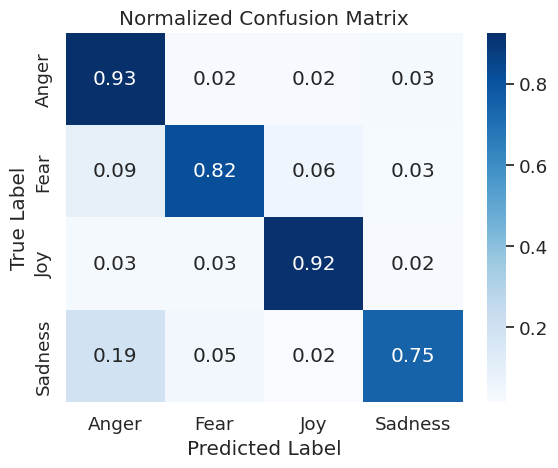

In [22]:
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=True, xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=CLASS_LABELS, output_dict=True)

print("{:<15} {:<15} {:<15} {:<15}".format("Class", "Precision", "Recall", "F1-Score"))
print("========================================================")
for class_label, metrics in report.items():
    if class_label in CLASS_LABELS:
        print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(class_label, metrics['precision'], metrics['recall'], metrics['f1-score']))

print("\nOverall Accuracy: {:.4f}".format(report['accuracy']))

Class           Precision       Recall          F1-Score       
Anger           0.6905          0.9255          0.7909         
Fear            0.8962          0.8190          0.8559         
Joy             0.8922          0.9192          0.9055         
Sadness         0.9238          0.7462          0.8255         

Overall Accuracy: 0.8428


In [24]:
# Classwise Accuracies
classwise_accuracy = np.diag(cm) / cm.sum(axis=1)
print("Class        Accuracy")
print("=====================")
for class_label, accuracy in zip(CLASS_LABELS, classwise_accuracy):
    print(f"{class_label:<12} {accuracy:>8.2f}")

Class        Accuracy
Anger            0.93
Fear             0.82
Joy              0.92
Sadness          0.75
